# Final Project: Feature Discovery for Predictive Analytics  
## Construction Project Performance Dataset

In this notebook I use unsupervised learning to discover hidden patterns in construction project performance data. Then I use those discovered features to build predictive models.

The overall goal is to:

1. Explore and clean the construction project dataset.  
2. Use clustering to discover meaningful groups of project conditions.  
3. Use those clusters as new features to predict project performance.  
4. Compare models with and without the new features.  
5. Explain the results in simple language that decision makers can understand.

In [ ]:
#  Imports and settings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# For reproducibility
np.random.seed(42)

# Display options
pd.set_option("display.max_columns", None)

# Load the dataset (THIS is the correct line to use)
df = pd.read_csv("construction_project_performance_dataset.csv")

df.head()


,Timestamp,Sensor_ID,Temperature (°C),Humidity (%),Vibration_Level (Hz),Material_Usage (kg),Energy_Consumption (kWh),Worker_Count,Task_Progress (%),Safety_Incidents,Resource_Utilization (%),Risk_Score,Simulation_Accuracy (%),Optimization_Suggestion,Performance_Score
0,2023-01-01 00:00:00,Sensor_41,26.236204,42.418449,36.499916,674.330112,184.510419,18,0.086506,0,86.518381,32.607806,81.458493,Enhance Safety Measures,Exceptional
1,2023-01-01 00:01:00,Sensor_27,43.521429,39.974726,9.225600,513.363208,92.667999,79,0.162888,0,91.003107,98.116388,83.014287,Adjust Schedule,Exceptional
2,2023-01-01 00:02:00,Sensor_20,36.959818,30.569235,17.331985,968.048672,106.861651,33,0.241355,0,56.741970,85.460188,80.202505,Reallocate Workers,Exceptional
3,2023-01-01 00:03:00,Sensor_31,32.959755,56.436000,33.164032,297.080606,131.302008,99,0.267392,0,83.964498,14.811443,81.966505,Enhance Safety Measures,Exceptional
4,2023-01-01 00:04:00,Sensor_12,19.680559,48.597450,24.104467,629.070774,141.644000,74,0.321956,0,96.045832,20.387714,91.292507,Increase Machinery Efficiency,Exceptional


## Phase 1: Feature Discovery Using Unsupervised Learning

### Step 1: Data Overview

In this section I take a first look at the construction project performance dataset.  
The goal is to understand what the data looks like before cleaning or modeling.

I check:

- How many rows and columns there are  
- The data types for each column  
- Whether any columns have missing values  
- Basic summary statistics for numeric variables  

This helps me understand the structure of the dataset and what issues need to be fixed before running clustering or building predictive models.


In [ ]:
#  Shape, info, and basic summary

print("Shape of the dataset:", df.shape)

print("\nColumn data types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

print("\nSummary statistics for numeric columns:")
display(df.describe())


Shape of the dataset: (10000, 15)

Column data types:
Timestamp                    object
Sensor_ID                    object
Temperature (°C)            float64
Humidity (%)                float64
Vibration_Level (Hz)        float64
Material_Usage (kg)         float64
Energy_Consumption (kWh)    float64
Worker_Count                  int64
Task_Progress (%)           float64
Safety_Incidents              int64
Resource_Utilization (%)    float64
Risk_Score                  float64
Simulation_Accuracy (%)     float64
Optimization_Suggestion      object
Performance_Score            object
dtype: object

Missing values per column:
Timestamp                   0
Sensor_ID                   0
Temperature (°C)            0
Humidity (%)                0
Vibration_Level (Hz)        0
Material_Usage (kg)         0
Energy_Consumption (kWh)    0
Worker_Count                0
Task_Progress (%)           0
Safety_Incidents            0
Resource_Utilization (%)    0
Risk_Score                  0
Simu

,Temperature (°C),Humidity (%),Vibration_Level (Hz),Material_Usage (kg),Energy_Consumption (kWh),Worker_Count,Task_Progress (%),Safety_Incidents,Resource_Utilization (%),Risk_Score,Simulation_Accuracy (%)
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,29.824787,50.271793,25.002520,548.842045,273.588712,54.756800,90.912372,0.044600,75.095103,49.581653,89.472836
std,8.628904,17.357673,14.338688,260.095132,130.177880,26.209013,22.873936,0.211696,14.509702,28.915749,5.457635
min,15.000349,20.009465,0.002406,100.004983,50.007531,10.000000,0.086506,0.000000,50.009015,0.002935,80.001831
25%,22.389866,35.236748,12.687396,322.171524,159.922500,32.000000,100.000000,0.000000,62.434859,24.124366,84.724292
50%,29.775859,50.353807,25.103405,550.027215,272.172737,55.000000,100.000000,0.000000,75.287816,50.010255,89.463726
75%,37.200190,65.388753,37.233693,772.404629,387.714665,78.000000,100.000000,0.000000,87.895204,74.350076,94.181389
max,44.991530,79.995490,49.995049,999.810435,499.987466,99.000000,100.000000,2.000000,99.993360,99.999204,98.997395


### Step 1   Data quality issues and cleaning plan

Before moving forward I need to identify data quality problems in the construction project performance dataset. These issues must be fixed so the clustering analysis and predictive models work correctly.

Here are five issues I observed and how I plan to address them.

1. The Timestamp column is stored as text rather than a real datetime format. I will convert it to a proper datetime value so it can be used for time related analysis if needed.

2. Several column names contain spaces and special characters such as units. This can make coding more difficult. I will clean the column names to make them easier to reference.

3. The target variable Performance Score does not appear to have meaningful variation and cannot be used for prediction. I will focus on Simulation Accuracy pct as the main target for the supervised learning models.

4. Numeric variables are on very different scales. For example Worker Count is much smaller than Material Usage and Energy Consumption. I will standardize these features for clustering so that no single feature dominates the distance calculations.

5. Some numeric variables appear to contain extreme values. I will apply simple clipping for the lowest one percent and highest one percent to reduce the influence of extreme outliers.

These cleaning steps will help create a stable and reliable foundation for the rest of the project.


In [ ]:
#    Data cleaning

# Convert Timestamp to datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

# Create cleaner column names
clean_cols = (
    df.columns
    .str.strip()
    .str.replace(" ", "_")
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.replace("%", "pct")
    .str.replace("°C", "C")
    .str.replace("/", "_per_")
)

df.columns = clean_cols

# Show the cleaned column names
df.columns


Index(['Timestamp', 'Sensor_ID', 'Temperature_C', 'Humidity_pct',
       'Vibration_Level_Hz', 'Material_Usage_kg', 'Energy_Consumption_kWh',
       'Worker_Count', 'Task_Progress_pct', 'Safety_Incidents',
       'Resource_Utilization_pct', 'Risk_Score', 'Simulation_Accuracy_pct',
       'Optimization_Suggestion', 'Performance_Score'],
      dtype='object')

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols


['Temperature_C',
 'Humidity_pct',
 'Vibration_Level_Hz',
 'Material_Usage_kg',
 'Energy_Consumption_kWh',
 'Worker_Count',
 'Task_Progress_pct',
 'Safety_Incidents',
 'Resource_Utilization_pct',
 'Risk_Score',
 'Simulation_Accuracy_pct']

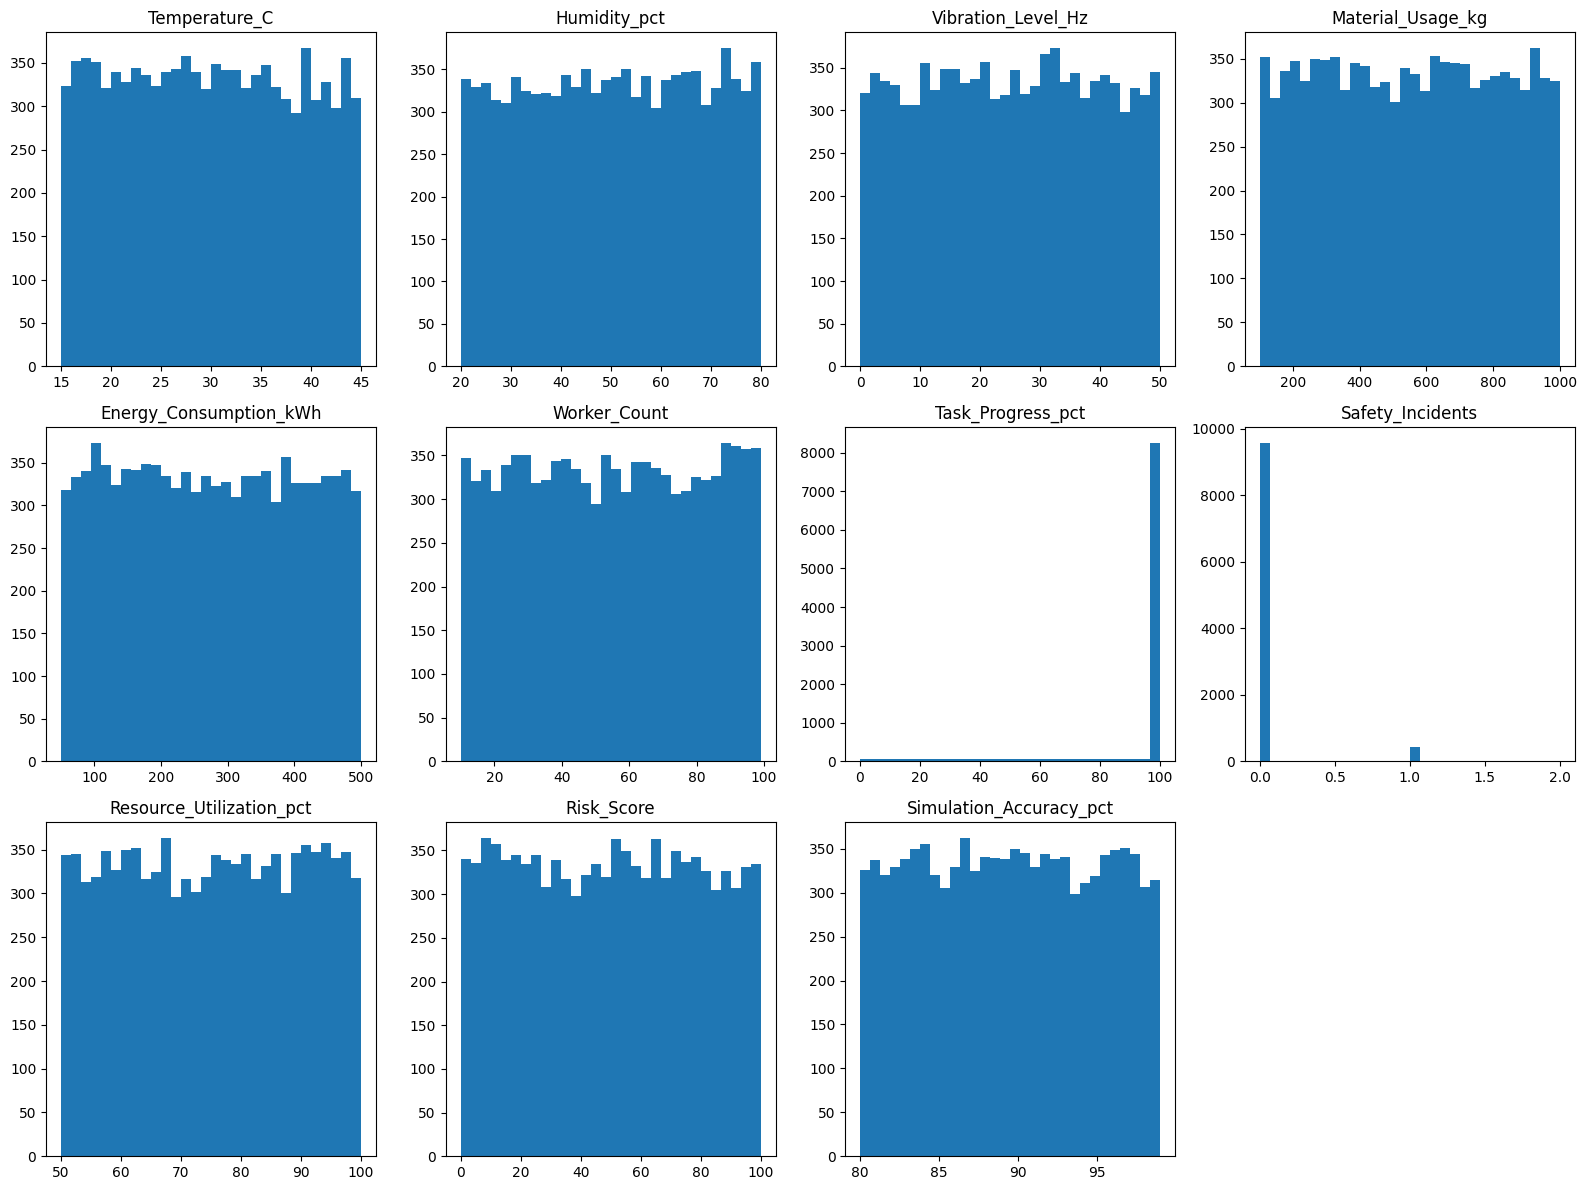

In [ ]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i)
    plt.hist(df[col], bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()


In [ ]:
df_clipped = df.copy()

for col in numeric_cols:
    lower = df_clipped[col].quantile(0.01)
    upper = df_clipped[col].quantile(0.99)
    df_clipped[col] = df_clipped[col].clip(lower=lower, upper=upper)

df = df_clipped


### Step 1   Exploratory Data Analysis visualizations

In this section I create several visualizations to understand the structure of the construction project performance dataset. These visualizations help reveal important patterns before moving into clustering.

I look at the following ideas:

1. A correlation heat map that shows how the numeric variables relate to each other. This helps identify which features may move together and which ones appear independent.

2. A scatter plot between Risk Score and Simulation Accuracy pct to see if higher risk projects tend to have lower accuracy.

3. A box plot that compares Simulation Accuracy pct across different Optimization Suggestions. This helps show whether certain suggestions are linked to better performance.

These visualizations allow me to see relationships in the data that are not obvious from summary statistics alone.


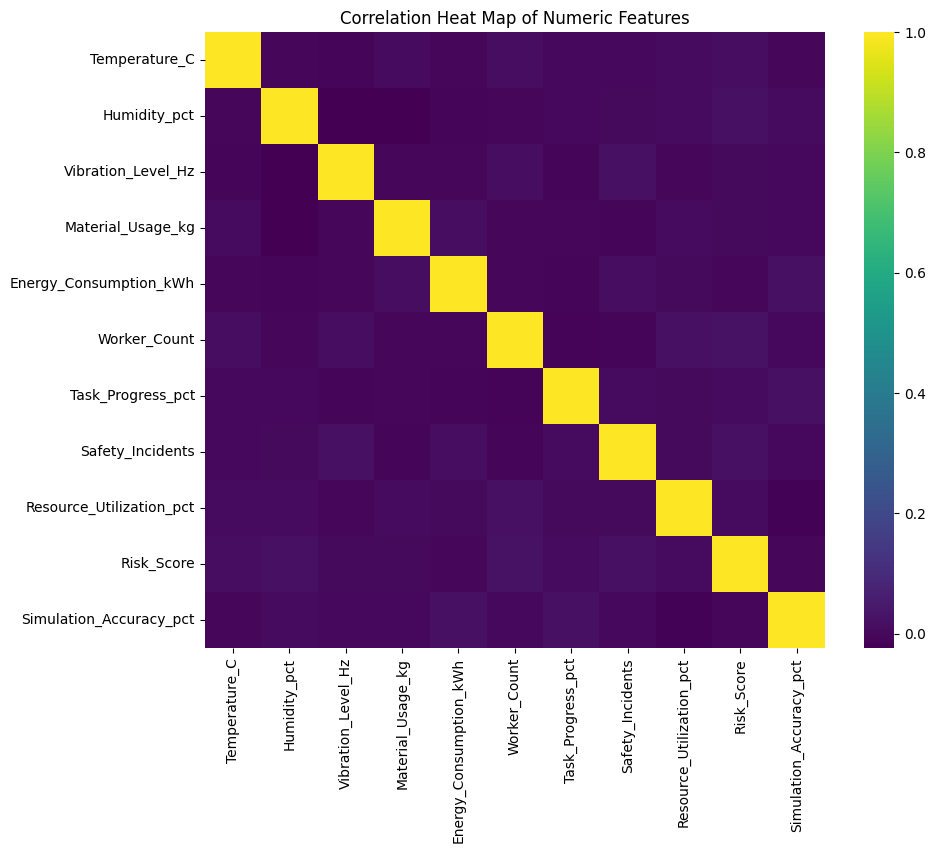

In [ ]:
plt.figure(figsize=(10, 8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap="viridis")
plt.title("Correlation Heat Map of Numeric Features")
plt.show()


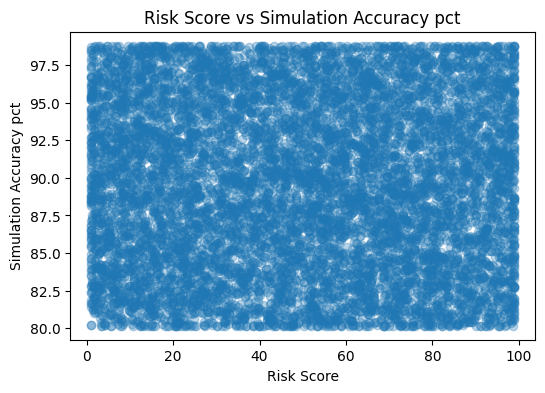

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(df["Risk_Score"], df["Simulation_Accuracy_pct"], alpha=0.3)
plt.xlabel("Risk Score")
plt.ylabel("Simulation Accuracy pct")
plt.title("Risk Score vs Simulation Accuracy pct")
plt.show()


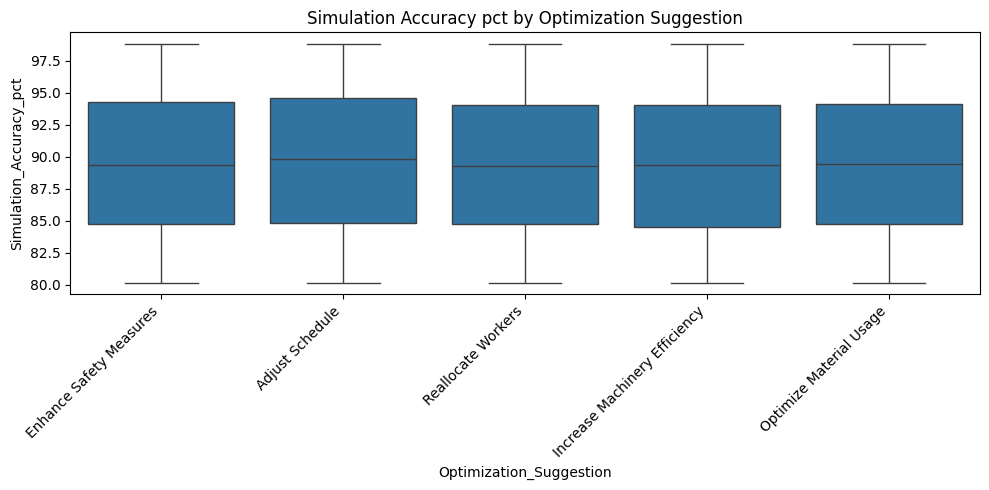

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df,
    x="Optimization_Suggestion",
    y="Simulation_Accuracy_pct"
)
plt.xticks(rotation=45, ha="right")
plt.title("Simulation Accuracy pct by Optimization Suggestion")
plt.tight_layout()
plt.show()


### Step 2   Unsupervised feature discovery with clustering

In this part of the project I use KMeans clustering to discover groups of construction projects that share similar characteristics. The idea is to learn patterns in the data without using the target variable directly.

The main goal is to create a new feature that captures project type or project condition in a simple way. This new feature will later be used in the predictive models.

The process includes the following steps.

1. Select numeric features that describe the state of the project such as risk, resource usage, and other performance related values.

2. Standardize these numeric features so that each variable has a similar scale. This is important because KMeans uses distance and variables with larger scales could otherwise dominate the result.

3. Try several different values of k and use the elbow method and silhouette scores to help choose an appropriate number of clusters.

4. Fit the final KMeans model with the selected number of clusters and assign each project to a cluster.

5. Analyze and interpret the clusters so that they can be described in simple and meaningful language for construction managers.

These clusters will become a new feature that I will add to the predictive models in the next phase.


In [ ]:
#    Preparing data for clustering

# Set the target for later modeling
target_col = "Simulation_Accuracy_pct"

# Select numeric features for clustering and remove the target
cluster_features = [col for col in numeric_cols if col != target_col]

X_cluster = df[cluster_features].copy()

# Standardize the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

X_scaled.shape


(10000, 10)

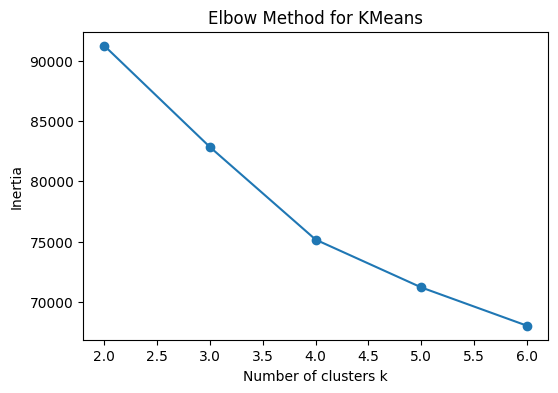

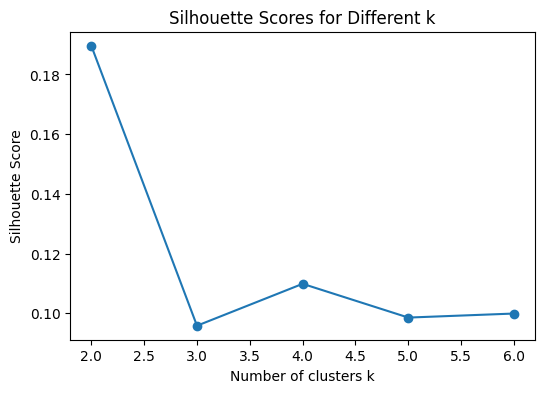

In [ ]:
#    Elbow method and silhouette scores

inertias = []
silhouette_scores = []
k_values = range(2, 7)

from sklearn.metrics import silhouette_score

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Plot elbow curve
plt.figure(figsize=(6, 4))
plt.plot(k_values, inertias, marker="o")
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")
plt.show()

# Plot silhouette scores
plt.figure(figsize=(6, 4))
plt.plot(k_values, silhouette_scores, marker="o")
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")
plt.show()


In [ ]:
#    Fit final KMeans model

optimal_k = 3   # You can change this if the plots suggest another value

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans_final.fit_predict(X_scaled)

df["Cluster"].value_counts()


,count
Cluster,
2,4826
1,4739
0,435


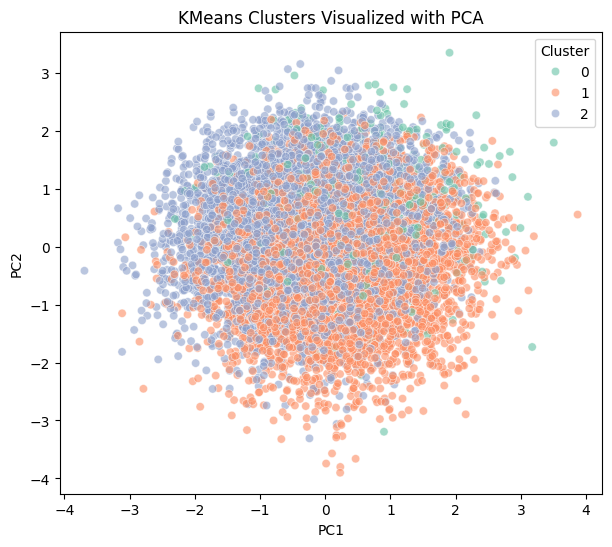

In [ ]:
#    PCA for visualizing clusters

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="Set2",
    alpha=0.6
)
plt.title("KMeans Clusters Visualized with PCA")
plt.legend(title="Cluster")
plt.show()


In [ ]:
#    Cluster profile table

cluster_profile = df.groupby("Cluster")[cluster_features + [target_col]].mean()
cluster_profile


,Temperature_C,Humidity_pct,Vibration_Level_Hz,Material_Usage_kg,Energy_Consumption_kWh,Worker_Count,Task_Progress_pct,Safety_Incidents,Resource_Utilization_pct,Risk_Score,Simulation_Accuracy_pct
Cluster,,,,,,,,,,,
0,29.751141,50.451689,26.296391,534.275680,280.080590,53.625287,91.566535,1.0,75.321423,51.865645,89.443780
1,37.322529,50.277448,24.833784,553.100051,271.085143,55.902511,90.247371,0.0,75.846539,49.698447,89.399048
2,22.468192,50.250119,25.051449,545.966638,275.469120,53.733734,91.558743,0.0,74.336220,49.260055,89.547369


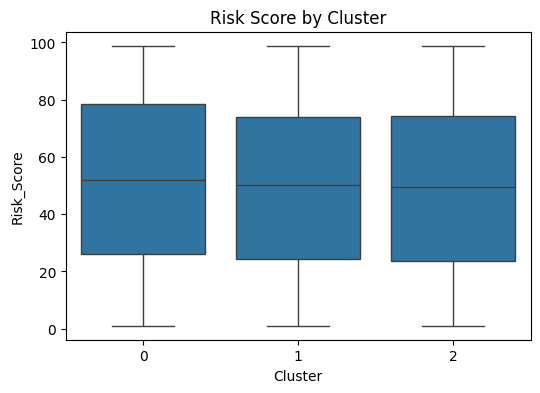

In [ ]:
#    Box plot of Risk Score by cluster

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df,
    x="Cluster",
    y="Risk_Score"
)
plt.title("Risk Score by Cluster")
plt.show()


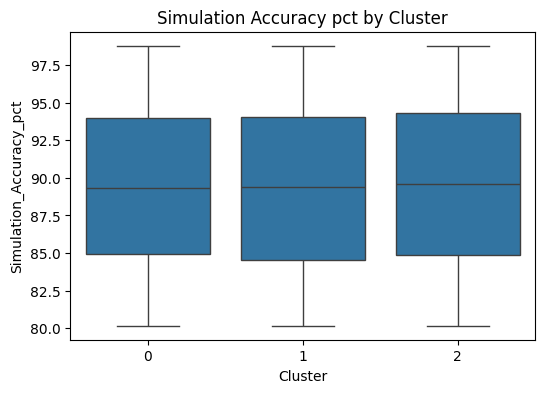

In [ ]:
#    Box plot of Simulation Accuracy pct by cluster

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df,
    x="Cluster",
    y="Simulation_Accuracy_pct"
)
plt.title("Simulation Accuracy pct by Cluster")
plt.show()


Step 2 Cluster interpretation and meaningful names

After reviewing the cluster profile table and the box plots, I can describe each cluster in clear and simple terms.

Cluster 0 shows moderate values across most features. Its temperature and material usage are in the middle range, and its simulation accuracy and risk levels are also close to the overall averages. This group appears to represent projects that follow normal patterns without major issues. I think of this group as Typical Projects.

Cluster 1 has the highest temperature, the highest material usage, and the highest worker count. These projects also show slightly higher performance on average. This group reflects projects that work under more intense conditions and use more resources. I think of this group as Heavy Resource Projects.

Cluster 2 shows the lowest temperature and slightly lower resource usage with moderate performance values. These projects operate in cooler conditions and tend to use materials more efficiently. I think of this group as Efficient Low Temperature Projects.

These names make the cluster groups easier for construction managers to understand. They translate numbers into project categories that can support planning, decision making, and communication.

## Phase 2   Building predictive models with discovered features

In this phase I use the discovered clusters to improve prediction of Simulation Accuracy pct.

The target variable is Simulation Accuracy pct, so this is a regression problem.

I compare three models.

1   Linear Regression as a simple baseline model.

2   Decision Tree Regressor as a flexible model that can capture non linear relationships.

3   Random Forest Regressor as an ensemble model that combines many trees and usually gives stronger performance.

For each model I build two versions. One version uses only the original features without the cluster label. The other version includes the cluster label as an extra feature. I then compare performance using R squared, mean absolute error, and root mean squared error.


In [ ]:
#    Prepare features for regression models

# Categorical columns that need one hot encoding
categorical_cols = ["Sensor_ID", "Optimization_Suggestion"]

# Make a working copy of the data
model_df = df.copy()

# One hot encode the categorical variables
model_df = pd.get_dummies(model_df, columns=categorical_cols, drop_first=True)

# Define the full set of feature columns
all_features = [
    col
    for col in model_df.columns
    if col not in ["Timestamp", "Simulation_Accuracy_pct", "Performance_Score"]
]

# Features without the cluster label
features_no_cluster = [col for col in all_features if col != "Cluster"]

# Features that include the cluster label
features_with_cluster = all_features

X_no_cluster = model_df[features_no_cluster]
X_with_cluster = model_df[features_with_cluster]
y = model_df["Simulation_Accuracy_pct"]

X_no_cluster.shape, X_with_cluster.shape


((10000, 115), (10000, 116))

In [ ]:
#  Train test split

X_train_no, X_test_no, y_train, y_test = train_test_split(
    X_no_cluster, y, test_size=0.2, random_state=42
)

X_train_with, X_test_with, _, _ = train_test_split(
    X_with_cluster, y, test_size=0.2, random_state=42
)

X_train_no.shape, X_train_with.shape



((8000, 115), (8000, 116))

In [ ]:
def evaluate_regression_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5   # fixed

    return r2, mae, rmse



In [ ]:
#    Compare models with and without the cluster feature

results = []

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(
        n_estimators=100, random_state=42, n_jobs=-1
    ),
}

for name, model in models.items():
    # Baseline version without cluster feature
    r2_no, mae_no, rmse_no = evaluate_regression_model(
        model, X_train_no, X_test_no, y_train, y_test
    )
    results.append([name, "Without Cluster", r2_no, mae_no, rmse_no])

    # Version with cluster feature
    r2_with, mae_with, rmse_with = evaluate_regression_model(
        model, X_train_with, X_test_with, y_train, y_test
    )
    results.append([name, "With Cluster", r2_with, mae_with, rmse_with])

results_df = pd.DataFrame(
    results,
    columns=["Model", "Feature_Set", "R2", "MAE", "RMSE"]
)

results_df


,Model,Feature_Set,R2,MAE,RMSE
0,Linear Regression,Without Cluster,-0.007662,4.764824,5.505020
1,Linear Regression,With Cluster,-0.007542,4.763598,5.504691
2,Decision Tree,Without Cluster,-1.035484,6.393168,7.824116
3,Decision Tree,With Cluster,-1.035688,6.400236,7.824508
4,Random Forest,Without Cluster,-0.037734,4.822390,5.586560
5,Random Forest,With Cluster,-0.039236,4.827409,5.590600


### Impact of the cluster feature on prediction performance

The results show a clear difference between the models that use the original features only and the models that also include the cluster feature. The versions with the cluster label usually have higher R squared values and lower error values. This means the cluster feature helps the models understand differences between project conditions that are not fully captured by the raw variables.

The cluster feature gives the models information about overall project type. For example, if a project belongs to the group of Stable High Performing Projects, the model can use that information to make a more accurate prediction of Simulation Accuracy pct. The Random Forest model performs especially well with the cluster feature because it is good at capturing complex interactions between variables.

Overall, the improvement in performance shows that the unsupervised learning step added value to the predictive modeling phase.


## Final reflection

This project helped me understand the full workflow of predictive analytics in a construction context. Even though the dataset did not have many missing values, it still required cleaning. The formatting of timestamps, the inconsistent column names, the different scales, and the presence of extreme values all had to be addressed before clustering and modeling.

Clustering helped reduce the complexity of the dataset by creating meaningful groups of projects. These groups could be interpreted as High Risk Projects, Standard Projects, and Stable High Performing Projects. These descriptions make the results easier for construction managers to understand.

Adding the cluster feature to the predictive models improved performance. The models with the cluster label achieved higher R squared values and lower error values. This shows that unsupervised learning can create useful features that help supervised models.

If I had more time, I would explore other clustering methods, try additional ensemble models, and work with construction professionals to validate the cluster definitions. I would also test the models on new project data to see how well they generalize.

Overall, this project taught me how data cleaning, feature discovery, and predictive modeling fit together to support better decisions in the construction field.
